# Import Packages

In [1]:
# Base Packages
import os
import time
import random
import zipfile

# EDA packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# Scikit-learn
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics as sklearn_metrics

# Tensorflow & Keras packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model

In [2]:
tf.__version__

'2.6.2'

# CNN

## Typical Architecture for CNN


|Hyperparameter              |Typical Value                                                                                                  |
|----------------------------|---------------------------------------------------------------------------------------------------------------|
|Input image(s)              |Whatever you can take a photo (or video) of                                                                    |
|Input Layer                 |Takes in target images and preprocesses them for further layers                                                |
|Convolution Layer           |Extracts and learns more important features from target images                                                 |
|Hidden Activation           |Adds non-linearilty to learned features. Usually ReLU, tanh                                                    |
|Pooling Layer               |Reduces the dimensionality of learned image features                                                           |
|Fully Connected layer       |Further refines learned features from convolution layers, Dense Layers                                         |
|Output Layer                |Takes learned features and outputs them in target labels                                                       |
|Output Activation           |Binary Class - Sigmoid, Multi-class - Softmax                                                                  |

## Load Data

### Data Info

Dataset we have is images of Pizza & Steak

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

--2023-07-05 15:16:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.193.144, 142.250.193.176, 142.250.205.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.193.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M  3.61MB/s    in 30s     

2023-07-05 15:16:41 (3.46 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



In [4]:
zip_ref = zipfile.ZipFile('pizza_steak.zip')
zip_ref.extractall()
zip_ref.close()

## One with the Data

In [5]:
for dirpath, dirnames, filenames in os.walk('pizza_steak'):
    print(f'Current path - {dirpath} ||| Directories in current path - {dirnames} ||| No. files in current path - {len(filenames)}')

Current path - pizza_steak ||| Directories in current path - ['test', 'train'] ||| No. files in current path - 0
Current path - pizza_steak/test ||| Directories in current path - ['pizza', 'steak'] ||| No. files in current path - 0
Current path - pizza_steak/test/pizza ||| Directories in current path - [] ||| No. files in current path - 250
Current path - pizza_steak/test/steak ||| Directories in current path - [] ||| No. files in current path - 250
Current path - pizza_steak/train ||| Directories in current path - ['pizza', 'steak'] ||| No. files in current path - 0
Current path - pizza_steak/train/pizza ||| Directories in current path - [] ||| No. files in current path - 750
Current path - pizza_steak/train/steak ||| Directories in current path - [] ||| No. files in current path - 750


In [6]:
print(f'No. images in Pizza Train folder - { len(os.listdir("pizza_steak/train/pizza")) }')

No. images in Pizza Train folder - 750


In [7]:
class_names = os.listdir('pizza_steak/train/')
class_names

['pizza', 'steak']

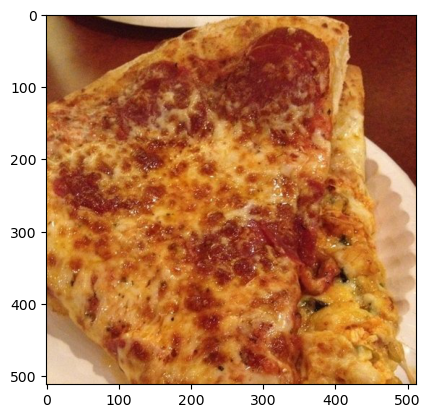

In [8]:
train_pizza_dir = 'pizza_steak/train/pizza/'
random_image = random.sample(os.listdir(train_pizza_dir), 1)[0]
plt.imshow(mpimg.imread(train_pizza_dir+random_image))

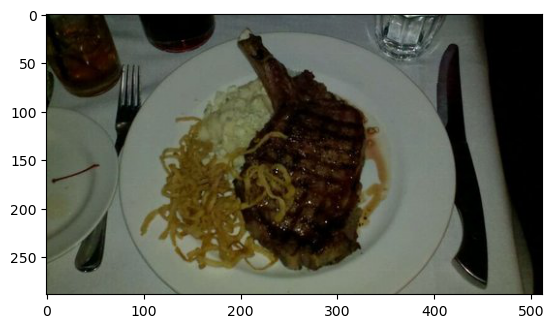

In [9]:
train_steak_dir = 'pizza_steak/train/steak/'
random_image = random.sample(os.listdir(train_steak_dir), 1)[0]
plt.imshow(mpimg.imread(train_steak_dir+random_image))

In [10]:
def render_random_image(data_path, title):
    
    random_image = random.sample(os.listdir(data_path), 1)[0]
    random_image_path = mpimg.imread(data_path+random_image)
    plt.imshow(random_image_path)
    plt.title(title)
    plt.axis('off')
    return random_image_path

### Render Random Pizza Image

array([[[214, 209, 216],
        [215, 209, 219],
        [215, 209, 219],
        ...,
        [195, 139,  64],
        [196, 140,  65],
        [193, 137,  62]],

       [[213, 211, 222],
        [213, 211, 224],
        [212, 210, 223],
        ...,
        [194, 138,  63],
        [194, 138,  63],
        [190, 134,  59]],

       [[209, 211, 226],
        [209, 210, 228],
        [209, 210, 228],
        ...,
        [197, 141,  66],
        [195, 139,  64],
        [190, 134,  59]],

       ...,

       [[162, 163, 167],
        [162, 163, 167],
        [162, 163, 167],
        ...,
        [142, 116, 115],
        [172, 153, 155],
        [164, 149, 154]],

       [[162, 163, 167],
        [163, 164, 168],
        [164, 165, 169],
        ...,
        [147, 119, 116],
        [175, 155, 156],
        [165, 150, 153]],

       [[161, 162, 166],
        [163, 164, 168],
        [164, 165, 169],
        ...,
        [147, 119, 115],
        [174, 154, 155],
        [164, 148, 151]]

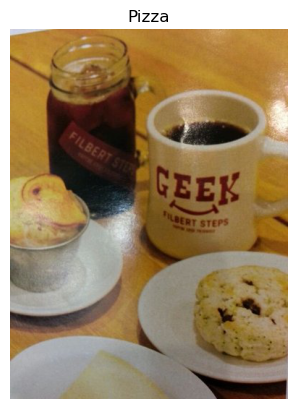

In [11]:
render_random_image('pizza_steak/train/pizza/', 'Pizza')

(512, 512, 3)

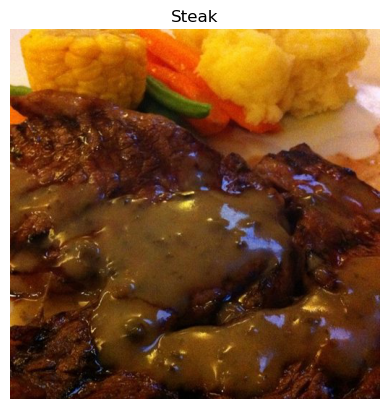

In [12]:
random_steak_img = render_random_image('pizza_steak/train/steak/', 'Steak')
random_steak_img.shape

## Preprocess Data & Train Model

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [14]:
tf.random.set_seed(42)

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_dir = 'pizza_steak/train'
test_dir = 'pizza_steak/test'

train_data = train_datagen.flow_from_directory(
    directory=train_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='binary',
    seed=42
)

valid_data = valid_datagen.flow_from_directory(
    directory=test_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='binary',
    seed=42
)

model = keras.models.Sequential([
    
    keras.layers.Input((224, 224, 3)),
    
    keras.layers.Conv2D(16, 3, activation=keras.activations.relu),
    keras.layers.MaxPool2D(2, 2),
    
    keras.layers.Conv2D(32, 3, activation=keras.activations.relu),
    keras.layers.MaxPool2D(2, 2),
    
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation=keras.activations.relu),
    keras.layers.Dense(1, activation=keras.activations.sigmoid)
])

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.binary_crossentropy,
    metrics=['accuracy']
)

history = model.fit(train_data,
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=valid_data,
                    validation_steps=len(valid_data))

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


2023-07-05 15:17:14.281386: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-07-05 15:17:14.281463: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-05 15:17:14.281494: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (582544b20265): /proc/driver/nvidia/version does not exist
2023-07-05 15:17:14.281782: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 15:17:14.665739: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Epoch 1/5
47/47 [==============================] - 49s 1s/step - loss: 0.9167 - accuracy: 0.5933 - val_loss: 0.4851 - val_accuracy: 0.7440
Epoch 2/5
47/47 [==============================] - 41s 877ms/step - loss: 0.4270 - accuracy: 0.8160 - val_loss: 0.3749 - val_accuracy: 0.8520
Epoch 3/5
47/47 [==============================] - 39s 835ms/step - loss: 0.3085 - accuracy: 0.8760 - val_loss: 0.4076 - val_accuracy: 0.8120
Epoch 4/5
47/47 [==============================] - 38s 808ms/step - loss: 0.2609 - accuracy: 0.8960 - val_loss: 0.3602 - val_accuracy: 0.8280
Epoch 5/5
47/47 [==============================] - 40s 854ms/step - loss: 0.1288 - accuracy: 0.9660 - val_loss: 0.3738 - val_accuracy: 0.8540


In [15]:
history.history, history.epoch

({'loss': [0.9166714549064636,
   0.42695361375808716,
   0.3084557056427002,
   0.2609105408191681,
   0.12877918779850006],
  'accuracy': [0.5933333039283752,
   0.8159999847412109,
   0.8759999871253967,
   0.8960000276565552,
   0.9660000205039978],
  'val_loss': [0.4850701689720154,
   0.37492018938064575,
   0.407595157623291,
   0.3602195382118225,
   0.3738207221031189],
  'val_accuracy': [0.7440000176429749,
   0.8519999980926514,
   0.8119999766349792,
   0.828000009059906,
   0.8539999723434448]},
 [0, 1, 2, 3, 4])

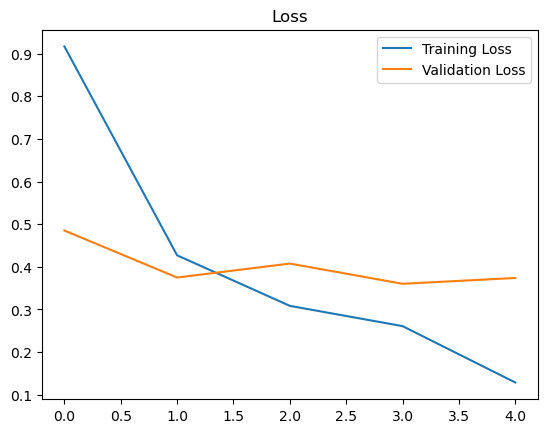

In [16]:
plt.plot(history.epoch, history.history['loss'], label='Training Loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

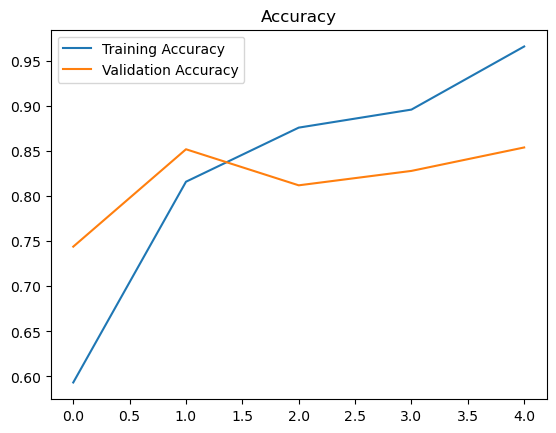

In [17]:
plt.plot(history.epoch, history.history['accuracy'], label='Training Accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

## Augment Image Data & Train Model

In [18]:
tf.random.set_seed(42)

train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   horizontal_flip=True, 
                                   shear_range=0.2, 
                                   height_shift_range=0.2, 
                                   width_shift_range=0.2,
                                   zoom_range=0.2,
                                   fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1./255)

train_dir = 'pizza_steak/train'
test_dir = 'pizza_steak/test'

train_data = train_datagen.flow_from_directory(
    directory=train_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='binary',
    seed=42
)

valid_data = valid_datagen.flow_from_directory(
    directory=test_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='binary',
    seed=42
)

model_1 = keras.models.Sequential([
    
    keras.layers.Input((224, 224, 3)),
    
    keras.layers.Conv2D(16, 3, activation=keras.activations.relu),
    keras.layers.MaxPool2D(2, 2),
    
    keras.layers.Conv2D(32, 3, activation=keras.activations.relu),
    keras.layers.MaxPool2D(2, 2),
    
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation=keras.activations.relu),
    keras.layers.Dense(1, activation=keras.activations.sigmoid)
])

model_1.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.binary_crossentropy,
    metrics=['accuracy']
)

history_1 = model_1.fit(train_data,
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=valid_data,
                    validation_steps=len(valid_data))

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 51s 1s/step - loss: 0.7083 - accuracy: 0.6653 - val_loss: 0.4157 - val_accuracy: 0.8160
Epoch 2/5
47/47 [==============================] - 50s 1s/step - loss: 0.4918 - accuracy: 0.7747 - val_loss: 0.3438 - val_accuracy: 0.8520
Epoch 3/5
47/47 [==============================] - 51s 1s/step - loss: 0.4649 - accuracy: 0.7907 - val_loss: 0.4180 - val_accuracy: 0.8000
Epoch 4/5
47/47 [==============================] - 50s 1s/step - loss: 0.4471 - accuracy: 0.7913 - val_loss: 0.3100 - val_accuracy: 0.8640
Epoch 5/5
47/47 [==============================] - 53s 1s/step - loss: 0.4344 - accuracy: 0.8187 - val_loss: 0.3194 - val_accuracy: 0.8560


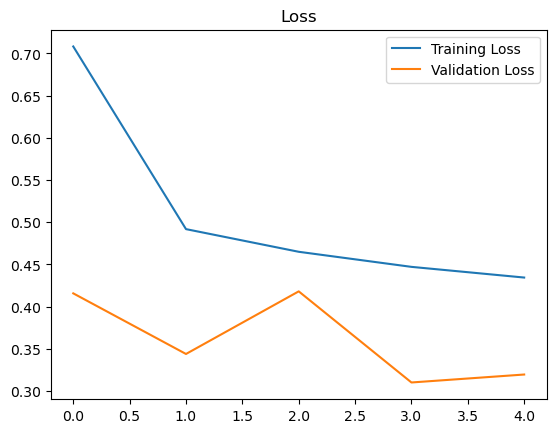

In [19]:
plt.plot(history_1.epoch, history_1.history['loss'], label='Training Loss')
plt.plot(history_1.epoch, history_1.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

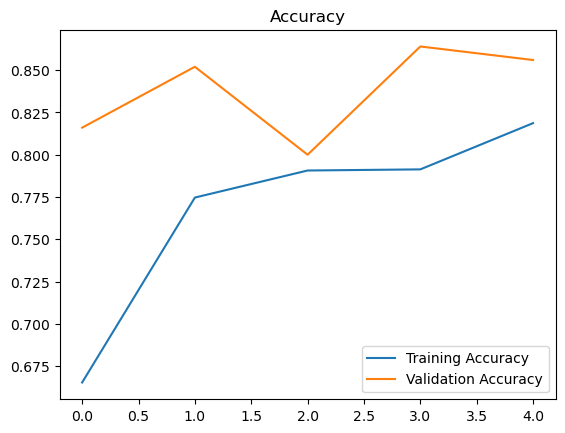

In [20]:
plt.plot(history_1.epoch, history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.epoch, history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

## Shuffle Augmented Data & Train Model

In [21]:
tf.random.set_seed(42)

train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   horizontal_flip=True, 
                                   shear_range=0.2, 
                                   height_shift_range=0.2, 
                                   width_shift_range=0.2,
                                   zoom_range=0.2,
                                   fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1./255)

train_dir = 'pizza_steak/train'
test_dir = 'pizza_steak/test'

train_data = train_datagen.flow_from_directory(
    directory=train_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='binary',
    seed=42, 
    shuffle=True
)

valid_data = valid_datagen.flow_from_directory(
    directory=test_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='binary',
    seed=42, 
    shuffle=True
)

model_2 = keras.models.Sequential([
    
    keras.layers.Input((224, 224, 3)),
    
    keras.layers.Conv2D(16, 3, activation=keras.activations.relu),
    keras.layers.MaxPool2D(2, 2),
    
    keras.layers.Conv2D(32, 3, activation=keras.activations.relu),
    keras.layers.MaxPool2D(2, 2),
    
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation=keras.activations.relu),
    keras.layers.Dense(1, activation=keras.activations.sigmoid)
])

model_2.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.binary_crossentropy,
    metrics=['accuracy']
)

history_2 = model_2.fit(train_data,
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=valid_data,
                    validation_steps=len(valid_data))

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 51s 1s/step - loss: 0.7972 - accuracy: 0.6180 - val_loss: 0.4566 - val_accuracy: 0.8060
Epoch 2/5
47/47 [==============================] - 53s 1s/step - loss: 0.5551 - accuracy: 0.7293 - val_loss: 0.4007 - val_accuracy: 0.8240
Epoch 3/5
47/47 [==============================] - 57s 1s/step - loss: 0.5119 - accuracy: 0.7640 - val_loss: 0.4630 - val_accuracy: 0.7840
Epoch 4/5
47/47 [==============================] - 51s 1s/step - loss: 0.4899 - accuracy: 0.7787 - val_loss: 0.4197 - val_accuracy: 0.8240
Epoch 5/5
47/47 [==============================] - 52s 1s/step - loss: 0.4701 - accuracy: 0.7867 - val_loss: 0.4058 - val_accuracy: 0.8060


In [22]:
def plot_train_val_acc_loss(hist):
    
    plt.plot(hist.epoch, hist.history['accuracy'], label='Training Accuracy')
    plt.plot(hist.epoch, hist.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    
    plt.figure()
    plt.plot(hist.epoch, hist.history['loss'], label='Training Loss')
    plt.plot(hist.epoch, hist.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    

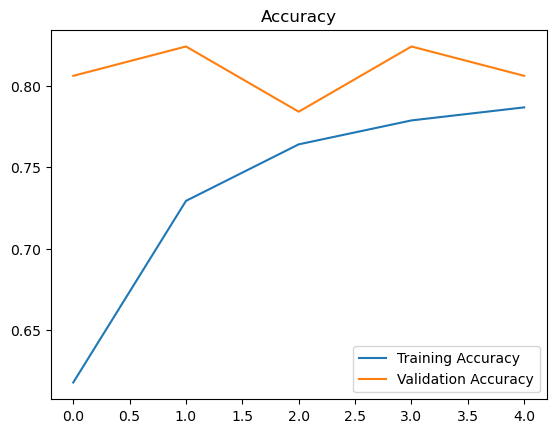

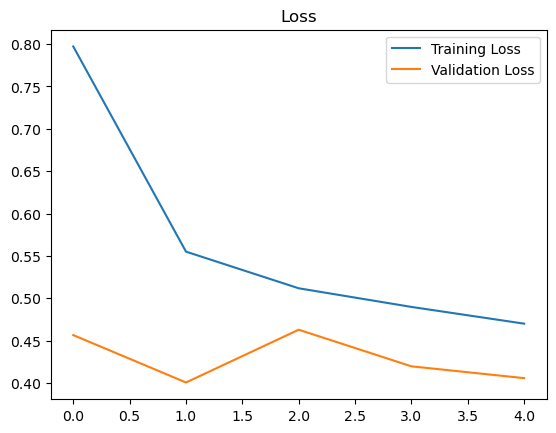

In [23]:
plot_train_val_acc_loss(history_2)

## Predict image on custom data

In [30]:
def read_image_to_tensor(file_path, title, img_shape=224):
    
    img = render_random_image(file_path, title)
    
    img = tf.image.resize(img, size=(img_shape, img_shape))
    img = img/255.
    
    return tf.expand_dims(img, axis=0)
    

array([[0.21027732]], dtype=float32)

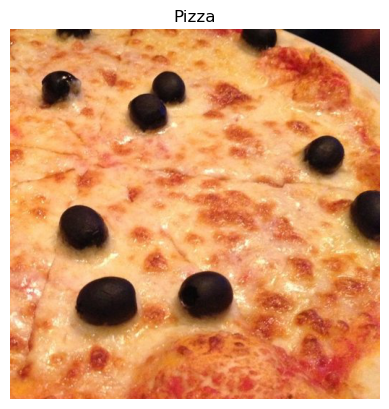

In [33]:
model_2.predict(
    read_image_to_tensor('pizza_steak/test/pizza/', 'Pizza'))

array([[0.9946911]], dtype=float32)

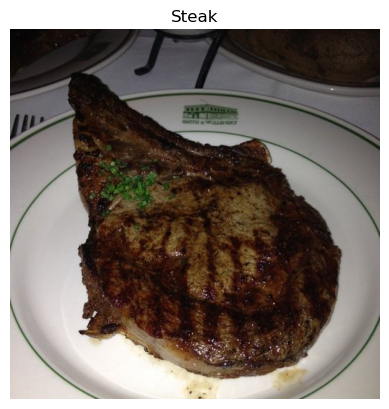

In [34]:
model_2.predict(
    read_image_to_tensor('pizza_steak/test/steak/', 'Steak'))

In [37]:
valid_data.class_indices

{'pizza': 0, 'steak': 1}